In [58]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
import joblib

In [59]:
# Download NLTK resources
nltk.download('punkt')  # For backward compatibility
nltk.download('punkt_tab')  # Required for tokenization
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rbats\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rbats\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rbats\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [71]:
# Step 1: Load and combine the CSV files
fake_df = pd.read_csv('fake.csv')
true_df = pd.read_csv('true.csv')

In [72]:
# Add label columns
fake_df['label'] = 'fake'
true_df['label'] = 'true'
# Combine datasets
df = pd.concat([fake_df, true_df], ignore_index=True)

# Handle missing values
df = df.dropna(subset=['text'])

In [73]:
# Step 2: Preprocess the text
def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_text'] = df['text'].apply(clean_text)

# Encode labels (fake=0, true=1)
df['label_encoded'] = df['label'].map({'fake': 0, 'true': 1})

In [74]:
# Step 3: Feature extraction with TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_text']).toarray()
y = df['label_encoded'].values

In [75]:
# Step 4: Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [76]:
# Step 5: Train Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [66]:
# Step 6: Evaluate on validation set
y_val_pred = model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred, target_names=['Fake', 'True']))

Validation Accuracy: 0.9885671863400148
Validation Classification Report:
               precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      3553
        True       0.99      0.99      0.99      3182

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



In [67]:
# Step 7: Evaluate on test set
y_test_pred = model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred, target_names=['Fake', 'True']))

Test Accuracy: 0.9882702301410542
Test Classification Report:
               precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      3538
        True       0.99      0.99      0.99      3197

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



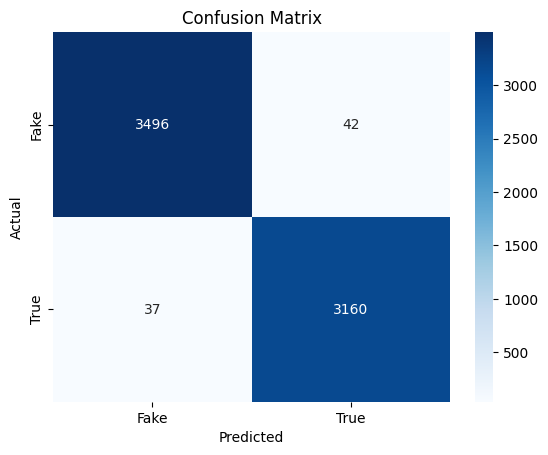

In [68]:
# Step 8: Visualize confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [69]:
# Step 9: Save the model and vectorizer
joblib.dump(model, 'fake_news_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [70]:
# Step 10: Test on new text
new_text = "This is a sample news article to test the model"
cleaned_text = clean_text(new_text)
features = tfidf.transform([cleaned_text]).toarray()
prediction = model.predict(features)
print("Prediction for new text:", 'Fake' if prediction[0] == 0 else 'True')

Prediction for new text: Fake
